# LIN approximation + correction factor
## Halfspaces conductivity
## Is it able to find the true conductivity?

1. We calculate all the exact solutions for all halfspaces
2. We calculate the LIN approximation solutions for all halfspaces
3. We calculate the correction factors of the solutions for all halfspaces
4. We invert from the LIN approximation solutions + correction factors the values for halfspaces

In [166]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
from scipy.constants import mu_0

### Define the geometry of device

In [167]:
# Define Dualem-482 geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meters height From ground surface to center of coils
rad = 0.08 # Define radius of coil (8 cm)

# Source and receivers geometry

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad,
              np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency
freq = 9000

### Define the properties of the halfspaces

In [168]:
# sampling of conductivities
nsl = 51

s0 = -4 # minimum conductivity in S/m
s1 = -0.5 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

### Define forward function that provides values of quadrature for each geometry

In [169]:
def EMforward(sigma):
    time.sleep(0.01)
    res =[2e14,10]
    depth=[0]
    res[1] = 1/sigma

    # Compute fields
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab=64, xdirect=None, verb=0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[2e14], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[2e14], freqtime=freq, ab=66, verb=0)

    Q_HCP = np.abs(np.imag(HCP_Hs/HCP_Hp))
    Q_VCP = np.abs(np.imag(VCP_Hs/VCP_Hp))
    Q_PRP = np.abs(np.imag(PRP_Hs/PRP_Hp))
       
    Q = np.hstack((Q_HCP, Q_VCP, Q_PRP))
    return Q

### Calculate the solutions for all the halfspaces

In [170]:
startTime = time.time()

Qexact = Parallel(n_jobs=-1,verbose=1)(delayed(EMforward)(sigma) for sigma in conds)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Execution time in seconds: 3.6392509937286377


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    3.6s finished


In [171]:
# Save the exact solutions for all the halfspaces
np.save('Qexact', Qexact)

In [172]:
# Compute correction factors for Qexact

def Q_from_Sigma(sigma, freq, mu_0, s):
    Q = sigma * (2 *np.pi * freq) * mu_0 * s**2 /4
    return Q

# Calculate quadratures from LIN approximation
Q_LIN=[]
for cond in conds:
    Q_LIN.append(Q_from_Sigma(cond, freq, mu_0, offsets))
Q_LIN=np.array(Q_LIN)

cfQ_HCP_2 =[]
cfQ_HCP_4 =[]
cfQ_HCP_8 =[]
cfQ_VCP_2 =[]
cfQ_VCP_4 =[]
cfQ_VCP_8 =[]
cfQ_PRP_2 =[]
cfQ_PRP_4 =[]
cfQ_PRP_8 =[]

for i in range(len(Qexact)):
    cfQ_HCP_2.append(Qexact[i][0] / Q_LIN[i][0])
    cfQ_HCP_4.append(Qexact[i][1] / Q_LIN[i][1])
    cfQ_HCP_8.append(Qexact[i][2] / Q_LIN[i][2])
    cfQ_VCP_2.append(Qexact[i][3] / Q_LIN[i][0])
    cfQ_VCP_4.append(Qexact[i][4] / Q_LIN[i][1])
    cfQ_VCP_8.append(Qexact[i][5] / Q_LIN[i][2])
    cfQ_PRP_2.append(Qexact[i][6] / Q_LIN[i][0])
    cfQ_PRP_4.append(Qexact[i][7] / Q_LIN[i][1])
    cfQ_PRP_8.append(Qexact[i][8] / Q_LIN[i][2])
    
cfQ =np.stack((cfQ_HCP_2, cfQ_HCP_4, cfQ_HCP_8, cfQ_VCP_2, cfQ_VCP_4, cfQ_VCP_8, cfQ_PRP_2, cfQ_PRP_4, cfQ_PRP_8))

np.save('corrfacQ', cfQ) # Store correction factors


Text(0.5, 0.98, 'HCP coil')

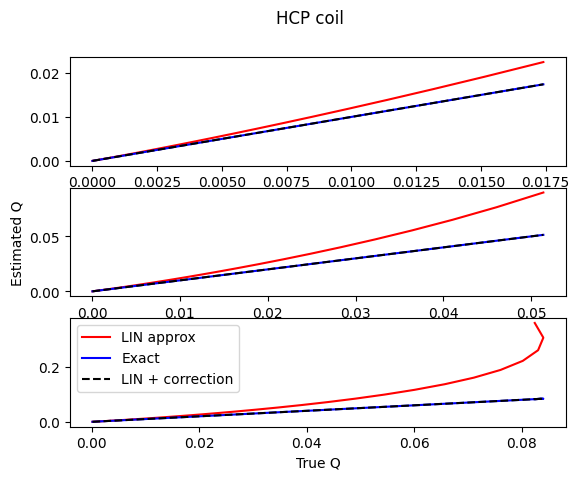

In [173]:
# Compare LIN approximation vs Exact solution

Qexact=np.load('Qexact.npy')

fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,0], np.array(Q_LIN)[:,0], 'r', label= 'LIN approx')
ax1.plot(Qexact[:,0], Qexact[:,0], 'b', label='Exact')
ax1.plot(Qexact[:,0], np.array(Q_LIN)[:,0] * np.array(cfQ_HCP_2), '--k', label='LIN + correction')

ax2.plot(Qexact[:,1], np.array(Q_LIN)[:,1], 'r', label= 'LIN approx')
ax2.plot(Qexact[:,1], Qexact[:,1], 'b', label='Exact')
ax2.plot(Qexact[:,1], np.array(Q_LIN)[:,1] * np.array(cfQ_HCP_4), '--k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')

ax3.plot(Qexact[:,2], np.array(Q_LIN)[:,2], 'r', label= 'LIN approx')
ax3.plot(Qexact[:,2], Qexact[:,2], 'b', label='Exact')
ax3.plot(Qexact[:,2], np.array(Q_LIN)[:,2] * np.array(cfQ_HCP_8), '--k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.legend()
fig.suptitle('HCP coil')


Text(0.5, 0.98, 'VCP coil')

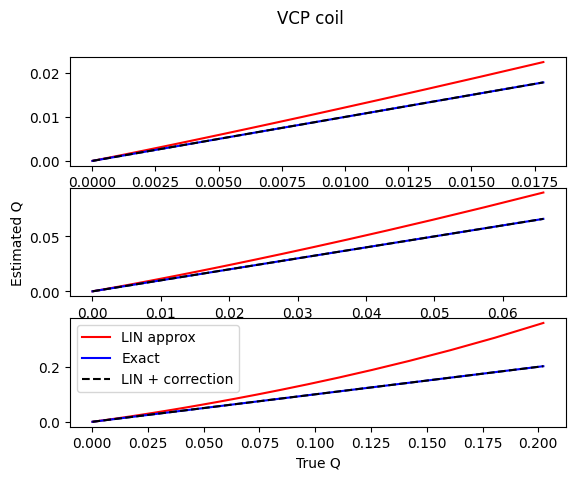

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,3], np.array(Q_LIN)[:,0], 'r', label= 'LIN approx')
ax1.plot(Qexact[:,3], Qexact[:,3], 'b', label='Exact')
ax1.plot(Qexact[:,3], np.array(Q_LIN)[:,0] * np.array(cfQ_VCP_2), '--k', label='LIN + correction')

ax2.plot(Qexact[:,4], np.array(Q_LIN)[:,1], 'r', label= 'LIN approx')
ax2.plot(Qexact[:,4], Qexact[:,4], 'b', label='Exact')
ax2.plot(Qexact[:,4], np.array(Q_LIN)[:,1] * np.array(cfQ_VCP_4), '--k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')

ax3.plot(Qexact[:,5], np.array(Q_LIN)[:,2], 'r', label= 'LIN approx')
ax3.plot(Qexact[:,5], Qexact[:,5], 'b', label='Exact')
ax3.plot(Qexact[:,5], np.array(Q_LIN)[:,2] * np.array(cfQ_VCP_8), '--k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.legend()
fig.suptitle('VCP coil')

Text(0.5, 0.98, 'PRP coil')

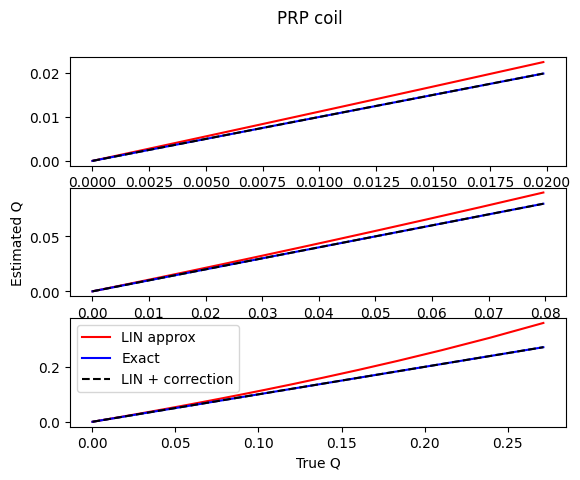

In [189]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,)

ax1.plot(Qexact[:,6], np.array(Q_LIN)[:,0], 'r', label= 'LIN approx')
ax1.plot(Qexact[:,6], Qexact[:,6], 'b', label='Exact')
ax1.plot(Qexact[:,6], np.array(Q_LIN)[:,0] * np.array(cfQ_PRP_2), '--k', label='LIN + correction')

ax2.plot(Qexact[:,7], np.array(Q_LIN)[:,1], 'r', label= 'LIN approx')
ax2.plot(Qexact[:,7], Qexact[:,7], 'b', label='Exact')
ax2.plot(Qexact[:,7], np.array(Q_LIN)[:,1] * np.array(cfQ_PRP_4), '--k', label='LIN + correction')
ax2.set_ylabel('Estimated Q')

ax3.plot(Qexact[:,8], np.array(Q_LIN)[:,2], 'r', label= 'LIN approx')
ax3.plot(Qexact[:,8], Qexact[:,8], 'b', label='Exact')
ax3.plot(Qexact[:,8], np.array(Q_LIN)[:,2] * np.array(cfQ_PRP_8), '--k', label='LIN + correction')
ax3.set_xlabel('True Q')
ax3.legend()
fig.suptitle('PRP coil')

### Define forward function for LIN approximation + correction factor

In [176]:
# Define cummulative sensitivity functions

# z is the normalized depth with respect to coil separation (depth/coil sep)

def CS_PRP(z):
    CS = 2*z / (np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_HCP(z):
    CS = 1 - 1/(np.sqrt(4 * z**2 + 1))
    return CS
    
def CS_VCP(z):
    CS = 1 - (np.sqrt(4 * z**2 + 1) - 2*z)
    return CS

# Load correction factors and exact solutions
CfQ = np.load('corrfacQ.npy')
Qexact = np.load('Qexact.npy')

# Correction function
def corrQ(Q_ap, geom):
    if geom == 'HCP2':
        idx = (np.abs(Q_ap-Q_LIN[:,0])).argmin()
        return CfQ[0, idx] 
    if geom == 'HCP4':
        idx = (np.abs(Q_ap-Q_LIN[:,1])).argmin()
        return CfQ[1, idx]
    if geom == 'HCP8':
        idx = (np.abs(Q_ap-Q_LIN[:,2])).argmin()
        return CfQ[2, idx]
    if geom == 'VCP2':
        idx = (np.abs(Q_ap-Q_LIN[:,0])).argmin()
        return CfQ[3, idx]
    if geom == 'VCP4':
        idx = (np.abs(Q_ap-Q_LIN[:,1])).argmin()
        return CfQ[4, idx]
    if geom == 'VCP8':
        idx = (np.abs(Q_ap-Q_LIN[:,2])).argmin()
        return CfQ[5, idx]
    if geom == 'PRP2':
        idx = (np.abs(Q_ap-Q_LIN[:,0])).argmin()
        return CfQ[6, idx]
    if geom == 'PRP4':
        idx = (np.abs(Q_ap-Q_LIN[:,1])).argmin()
        return CfQ[7, idx]
    if geom == 'PRP8':
        idx = (np.abs(Q_ap-Q_LIN[:,2])).argmin()
        return CfQ[8, idx]


In [177]:
def LINforward(sigma):
    Q_HCP = []
    Q_VCP = []
    Q_PRP = []
    
    for coil in offsets:
        sigma_app_HCP = sigma * (CS_HCP(1e6/coil))
        sigma_app_VCP = sigma * (CS_VCP(1e6/coil))
        sigma_app_PRP = sigma * (CS_PRP(1e6/coil))
        
        Q_HCP_ap = Q_from_Sigma(sigma_app_HCP, freq, mu_0, coil)
        Q_VCP_ap = Q_from_Sigma(sigma_app_VCP, freq, mu_0, coil)
        Q_PRP_ap = Q_from_Sigma(sigma_app_PRP, freq, mu_0, coil)
        
        Q_HCP.append(Q_HCP_ap * corrQ(Q_HCP_ap, 'HCP'+str(coil)))
        Q_VCP.append(Q_VCP_ap * corrQ(Q_VCP_ap, 'VCP'+str(coil)))
        Q_PRP.append(Q_PRP_ap * corrQ(Q_PRP_ap, 'PRP'+str(coil)))
        
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

### Create data with forward LIN + correction

In [206]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data=[]

s0 = -3 # minimum conductivity in S/m
s1 = -1 # maximum conductivity in S/m
# conductivities array
model_conds = np.logspace(s0, s1, nsl)

for i in range(len(conds)):
    model_i = model_conds[i] # True model 
    model.append(model_i)
    data.append(LINforward(model_i)) # creating data
    
# Relative error array
#error = 1e-1 # introduce here the error you want to test
#relativeError = np.ones_like(data[0]) * error

### Gridsearch function locates the index of the data that correspond to the halfspace in the look up table

In [207]:
def gridsearch(Qdata):
    err = 1
    indx=0
    for i in range(np.shape(Qexact)[0]):
        nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
        merr = np.log10(np.sqrt(np.sum(nZdiff)))
        if merr < err:
            indx = i
            err = merr.copy()
    return indx

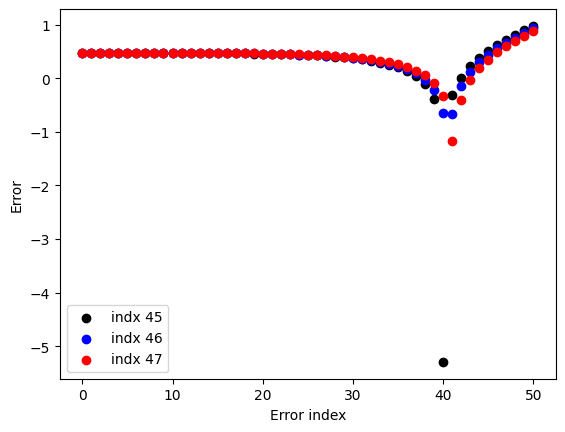

In [212]:
# Calculate errors for a single halfspace and plot

fig, ax = plt.subplots()
Qdata = LINforward(model_conds[45])
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = np.log10(np.sqrt(np.sum(nZdiff)))
    a = ax.scatter(i, merr, c='k',)
Qdata = LINforward(model_conds[46])
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = np.log10(np.sqrt(np.sum(nZdiff)))
    b = ax.scatter(i, merr, c='b',)
Qdata = LINforward(model_conds[47])
for i in range(np.shape(Qexact)[0]):
    nZdiff = np.abs(Qexact[i] - Qdata) **2 / np.abs(Qdata)**2
    merr = np.log10(np.sqrt(np.sum(nZdiff)))
    c = ax.scatter(i, merr, c='r',)
ax.set_xlabel('Error index')
ax.set_ylabel('Error')
ax.legend([a, b, c], ['indx 45', 'indx 46', 'indx 47'])
#plt.legend(['Halfspace indx 45', 'Halfspace indx 46', 'Halfspace indx 47'])

In [193]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(len(conds)):   
    dataE = np.array(data[i]).copy()
    #dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = conds[gridsearch(dataE)]
    
    model_est_list.append(model_est)

# Model estimation array  
model_est_arr = np.array(model_est_list)

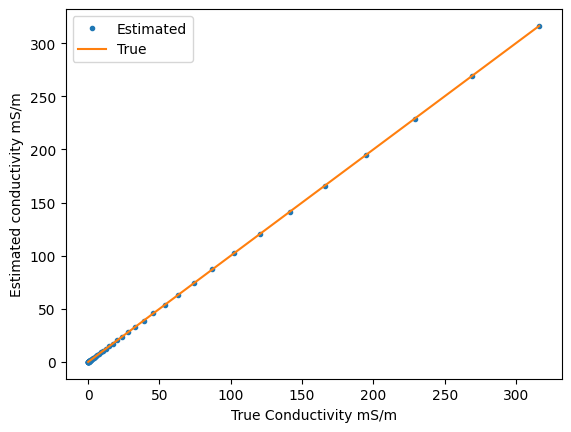

In [194]:
# Plot estimated model

plt.plot(model_conds*1000, model_est_arr*1000, '.', label='Estimated')
plt.plot(model_conds*1000, model_conds*1000, label = 'True')
plt.xlabel('True Conductivity mS/m')
plt.ylabel('Estimated conductivity mS/m')
plt.legend()